# Bioinformática en laboratorio — Sesión 05  
## Biopython: Árboles filogenéticos (Newick, distancia y parsimonia)

**Autores:** Raul Mendoza y Adrian Ojeda  
**Asignatura:** Bioinformatica (ULPGC)

En esta libreta resolvemos los **tres ejercicios** de la sesión:

1. **Ejercicio 1:** Leer un árbol en **Newick** y sacar información (nodos, terminales, longitudes, clados, etc.). fileciteturn2file0  
2. **Ejercicio 2:** Modificar el árbol (nombres, longitudes y resaltado visual) y volver a dibujarlo. fileciteturn2file0  
3. **Ejercicio 3:** A partir de un **FASTA**, construir árboles por **UPGMA**, **Neighbor-Joining** y **Máxima Parsimonia**, guardar en **Newick**, graficar y comparar resultados. fileciteturn2file0  


---
## 0) Preparación del entorno

Trabajamos con:
- `Bio.Phylo` para leer/dibujar árboles.
- `Bio.Phylo.TreeConstruction` para construir árboles por distancia y parsimonia.
- `AlignIO / SeqIO` para leer y escribir FASTA.
- `matplotlib` para representar árboles.


In [12]:

# !pip install biopython matplotlib

from Bio import Phylo, AlignIO, SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from Bio.Phylo.TreeConstruction import (
    DistanceCalculator,
    DistanceTreeConstructor,
    ParsimonyScorer,
    NNITreeSearcher,
    ParsimonyTreeConstructor
)

from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


---
# Ejercicio 1  
## Leer un árbol Newick y obtener información

El formato **Newick** representa un árbol con paréntesis, comas y un `;` final. fileciteturn2file0  
Los extremos del árbol se llaman **terminales** (hojas/taxones) y el resto son nodos internos.

Para que el notebook sea reproducible, usamos un Newick de ejemplo (si tú tienes `simple.dnd`, puedes sustituirlo).


<Figure size 1000x400 with 0 Axes>

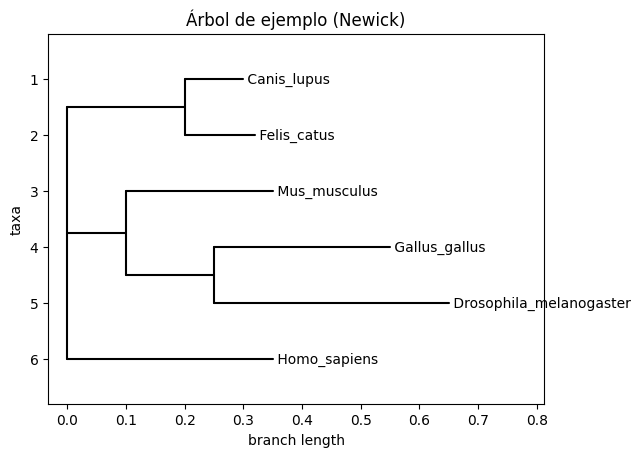

In [13]:

# Árbol de ejemplo en Newick (N=6 terminales)
newick_str = "((Canis_lupus:0.10,Felis_catus:0.12):0.20,(Mus_musculus:0.25,(Gallus_gallus:0.30,Drosophila_melanogaster:0.40):0.15):0.10,Homo_sapiens:0.35);"
tree = Phylo.read(StringIO(newick_str), "newick")

plt.figure(figsize=(10, 4))
Phylo.draw(tree, do_show=False)
plt.title("Árbol de ejemplo (Newick)")
plt.show()


### 1.1) Terminales, nodos internos y clados

In [14]:

terminals = tree.get_terminals()
all_clades = list(tree.find_clades())
internal_nodes = [c for c in all_clades if c not in terminals]

print("=== Resumen ===")
print("Total clados (incluye hojas):", len(all_clades))
print("Nodos internos:", len(internal_nodes))
print("Terminales:", len(terminals))

print("\nTerminales:")
for t in terminals:
    print(" -", t.name)


=== Resumen ===
Total clados (incluye hojas): 10
Nodos internos: 4
Terminales: 6

Terminales:
 - Canis_lupus
 - Felis_catus
 - Mus_musculus
 - Gallus_gallus
 - Drosophila_melanogaster
 - Homo_sapiens


### 1.2) Longitudes de rama

In [15]:

print("=== Longitudes de rama ===")
for clade in all_clades:
    label = clade.name if clade.name else "(interno sin nombre)"
    print(f"{label:30s} -> {clade.branch_length}")


=== Longitudes de rama ===
(interno sin nombre)           -> None
(interno sin nombre)           -> 0.2
Canis_lupus                    -> 0.1
Felis_catus                    -> 0.12
(interno sin nombre)           -> 0.1
Mus_musculus                   -> 0.25
(interno sin nombre)           -> 0.15
Gallus_gallus                  -> 0.3
Drosophila_melanogaster        -> 0.4
Homo_sapiens                   -> 0.35


### 1.3) Profundidad (distancia desde la raíz)

In [16]:

depths = tree.depths()
print("=== Distancia raíz -> terminal ===")
for t in terminals:
    print(f"{t.name:30s} -> {depths.get(t)}")


=== Distancia raíz -> terminal ===
Canis_lupus                    -> 0.30000000000000004
Felis_catus                    -> 0.32
Mus_musculus                   -> 0.35
Gallus_gallus                  -> 0.55
Drosophila_melanogaster        -> 0.65
Homo_sapiens                   -> 0.35


### 1.4) Clado interno más grande

In [17]:

def clade_size(clade):
    return len(clade.get_terminals())

internal_sizes = [(c, clade_size(c)) for c in internal_nodes]
internal_sizes_sorted = sorted(internal_sizes, key=lambda x: x[1], reverse=True)

top_clade, top_size = internal_sizes_sorted[0]
print("Clado interno con mas terminales:", top_size)
print("Terminales dentro de ese clado:")
for t in top_clade.get_terminals():
    print(" -", t.name)


Clado interno con mas terminales: 6
Terminales dentro de ese clado:
 - Canis_lupus
 - Felis_catus
 - Mus_musculus
 - Gallus_gallus
 - Drosophila_melanogaster
 - Homo_sapiens


---
# Ejercicio 2  
## Modificar el árbol: nombres, longitudes y resaltado visual

Para evitar el ImportError que a veces sale con `PhyloXML.Color`, resaltamos el taxón
coloreando **la etiqueta** (label) en rojo. fileciteturn2file0


<Figure size 1000x400 with 0 Axes>

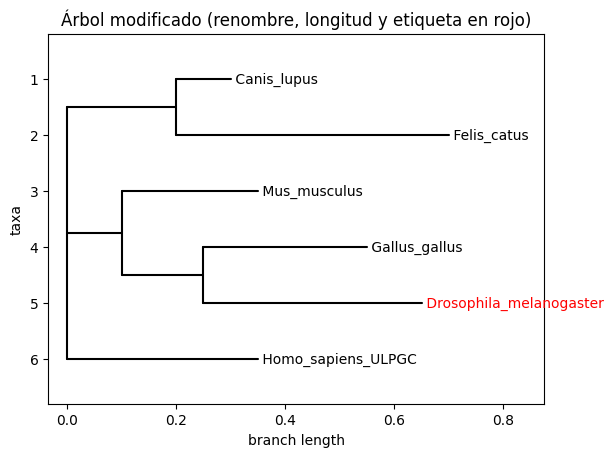

=== Terminales tras modificar ===
 - Canis_lupus | branch_length: 0.1
 - Felis_catus | branch_length: 0.5
 - Mus_musculus | branch_length: 0.25
 - Gallus_gallus | branch_length: 0.3
 - Drosophila_melanogaster | branch_length: 0.4
 - Homo_sapiens_ULPGC | branch_length: 0.35


In [18]:

tree2 = Phylo.read(StringIO(newick_str), "newick")

# Renombrar
for t in tree2.get_terminals():
    if t.name == "Homo_sapiens":
        t.name = "Homo_sapiens_ULPGC"

# Cambiar longitud
for t in tree2.get_terminals():
    if t.name == "Felis_catus":
        t.branch_length = 0.5

# Resaltar etiqueta en rojo
label_colors = {"Drosophila_melanogaster": "red"}

plt.figure(figsize=(10, 4))
Phylo.draw(tree2, do_show=False, label_colors=label_colors)
plt.title("Árbol modificado (renombre, longitud y etiqueta en rojo)")
plt.show()

print("=== Terminales tras modificar ===")
for t in tree2.get_terminals():
    print(" -", t.name, "| branch_length:", t.branch_length)


### 2.1) Guardar el árbol modificado en Newick

In [19]:

out_nwk = Path("arbol_modificado.nwk")
Phylo.write(tree2, out_nwk, "newick")
print("Guardado en:", out_nwk.resolve())
print(out_nwk.read_text())


Guardado en: C:\Users\raule\Documents\Universidad\4ºGCID\1 cuatri\BIO\Arboles\Biopython--rboles-filogen-ticos\arbol_modificado.nwk
((Canis_lupus:0.10000,Felis_catus:0.50000):0.20000,(Mus_musculus:0.25000,(Gallus_gallus:0.30000,Drosophila_melanogaster:0.40000):0.15000):0.10000,Homo_sapiens_ULPGC:0.35000):0.00000;



---
# Ejercicio 3  
## Construcción de árboles desde FASTA (UPGMA, NJ y Parsimonia)

Se pide cargar un FASTA y construir árboles usando:
- **Distancia** + UPGMA
- **Distancia** + Neighbor Joining
- **Máxima parsimonia**
Guardar en Newick y graficar. fileciteturn2file0


In [20]:

# FASTA del enunciado (primates)
fasta_text = ">Homo_sapiens\nATGCTAGCTAGCTACG--TACG\n>Pan_troglodytes\nATGCTAGCTAGCTACG--TACGA\n>Gorilla_gorilla\nATGCTAGCTAG-TACG--TACGA\n>Pongo_abelii\nATG-TAGCTAG-TACGCTTACGA\n>Macaca_mulatta\nATGATAG-TAG-TATGCTTATGA\n"

fasta_path = Path("primates.fasta")
fasta_path.write_text(fasta_text, encoding="utf-8")
print("FASTA guardado en:", fasta_path.resolve())


FASTA guardado en: C:\Users\raule\Documents\Universidad\4ºGCID\1 cuatri\BIO\Arboles\Biopython--rboles-filogen-ticos\primates.fasta


## 3.1) Alineamiento y matriz de distancias

In [21]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

records = list(SeqIO.parse(str(fasta_path), "fasta"))
max_len = max(len(r.seq) for r in records)

fixed = []
for r in records:
    s = str(r.seq)
    if len(s) < max_len:
        s = s + "-" * (max_len - len(s))   # rellenar al final con gaps
    fixed.append(SeqRecord(Seq(s), id=r.id, description=""))

SeqIO.write(fixed, str(fasta_path), "fasta")

# Ahora ya es un alineamiento valido
from Bio import AlignIO
alignment = AlignIO.read(str(fasta_path), "fasta")
print("OK. Longitud:", alignment.get_alignment_length())


OK. Longitud: 23


In [22]:

alignment = AlignIO.read(str(fasta_path), "fasta")
print("Numero de secuencias:", len(alignment))
print("Longitud alineamiento:", alignment.get_alignment_length())

calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)
dm


Numero de secuencias: 5
Longitud alineamiento: 23


DistanceMatrix(names=['Homo_sapiens', 'Pan_troglodytes', 'Gorilla_gorilla', 'Pongo_abelii', 'Macaca_mulatta'], matrix=[[0], [0.04347826086956519, 0], [0.08695652173913049, 0.04347826086956519, 0], [0.21739130434782605, 0.17391304347826086, 0.13043478260869568, 0], [0.34782608695652173, 0.30434782608695654, 0.26086956521739135, 0.17391304347826086, 0]])

In [23]:

# Par mas cercano (para guiar el UPGMA "a mano")
names = dm.names
min_val = 1e9
min_pair = None
for i in range(len(names)):
    for j in range(i+1, len(names)):
        v = dm[names[i], names[j]]
        if v < min_val:
            min_val = v
            min_pair = (names[i], names[j])

print("Par con menor distancia (inicio UPGMA):", min_pair, "dist =", min_val)


Par con menor distancia (inicio UPGMA): ('Homo_sapiens', 'Pan_troglodytes') dist = 0.04347826086956519


## 3.2) Árboles por distancia: UPGMA y NJ

<Figure size 1000x400 with 0 Axes>

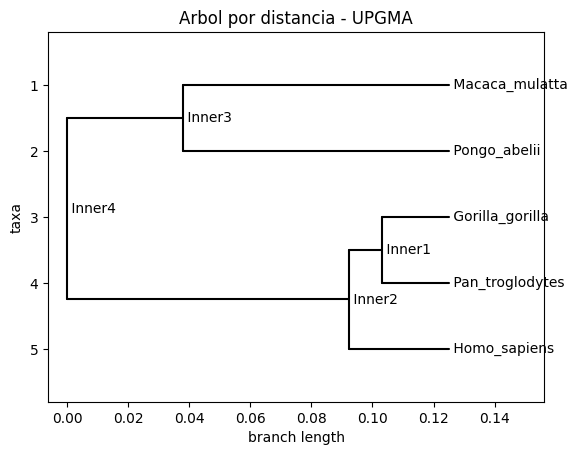

<Figure size 1000x400 with 0 Axes>

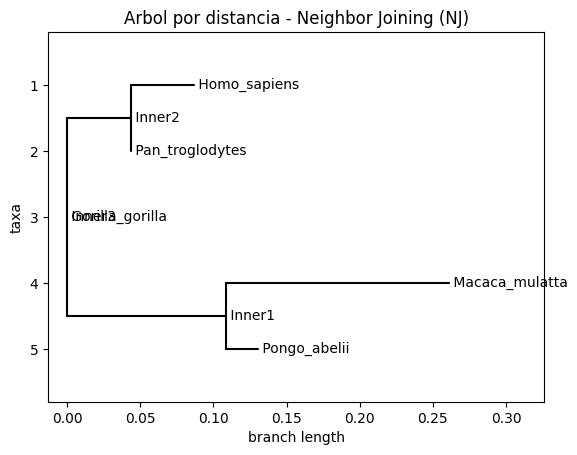

In [24]:

constructor_upgma = DistanceTreeConstructor(calculator, "upgma")
tree_upgma = constructor_upgma.build_tree(alignment)

constructor_nj = DistanceTreeConstructor(calculator, "nj")
tree_nj = constructor_nj.build_tree(alignment)

plt.figure(figsize=(10, 4))
Phylo.draw(tree_upgma, do_show=False)
plt.title("Arbol por distancia - UPGMA")
plt.show()

plt.figure(figsize=(10, 4))
Phylo.draw(tree_nj, do_show=False)
plt.title("Arbol por distancia - Neighbor Joining (NJ)")
plt.show()


## 3.2) Árbol por máxima parsimonia

<Figure size 1000x400 with 0 Axes>

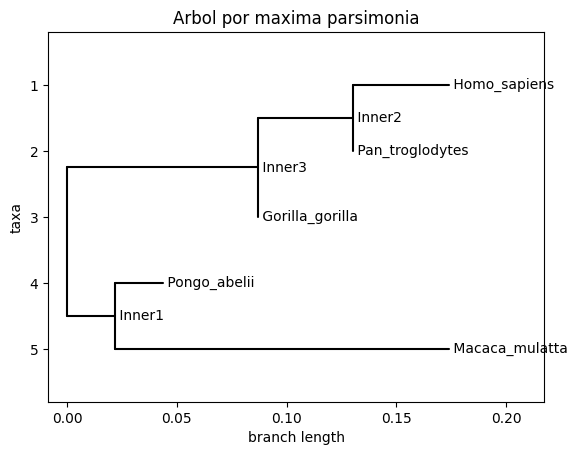

Score parsimonia: 9


In [25]:

scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
parsimony_constructor = ParsimonyTreeConstructor(searcher, tree_nj)
tree_parsimony = parsimony_constructor.build_tree(alignment)

plt.figure(figsize=(10, 4))
Phylo.draw(tree_parsimony, do_show=False)
plt.title("Arbol por maxima parsimonia")
plt.show()

print("Score parsimonia:", scorer.get_score(tree_parsimony, alignment))


## 3.3) Guardar en Newick

In [26]:

Phylo.write(tree_upgma, "primates_upgma.nwk", "newick")
Phylo.write(tree_nj, "primates_nj.nwk", "newick")
Phylo.write(tree_parsimony, "primates_parsimony.nwk", "newick")

print("UPGMA:", Path("primates_upgma.nwk").read_text().strip())
print("NJ   :", Path("primates_nj.nwk").read_text().strip())
print("Pars :", Path("primates_parsimony.nwk").read_text().strip())


UPGMA: ((Macaca_mulatta:0.08696,Pongo_abelii:0.08696)Inner3:0.03804,((Gorilla_gorilla:0.02174,Pan_troglodytes:0.02174)Inner1:0.01087,Homo_sapiens:0.03261)Inner2:0.09239)Inner4:0.00000;
NJ   : (((Homo_sapiens:0.04348,Pan_troglodytes:-0.00000)Inner2:0.04348,Gorilla_gorilla:0.00000)Inner3:0.08696,(Pongo_abelii:0.02174,Macaca_mulatta:0.15217)Inner1:0.02174):0.00000;
Pars : (((Homo_sapiens:0.04348,Pan_troglodytes:-0.00000)Inner2:0.04348,Gorilla_gorilla:0.00000)Inner3:0.08696,(Pongo_abelii:0.02174,Macaca_mulatta:0.15217)Inner1:0.02174):0.00000;


## 3.4) Comparación rápida (splits principales)

In [27]:

def major_splits(tree):
    splits = []
    for clade in tree.get_nonterminals():
        terms = tuple(sorted(t.name for t in clade.get_terminals()))
        if 1 < len(terms) < len(tree.get_terminals()):
            splits.append(terms)
    seen = set()
    out = []
    for s in splits:
        if s not in seen:
            seen.add(s)
            out.append(s)
    return out

print("=== Splits UPGMA ===")
for s in major_splits(tree_upgma):
    print(s)

print("\n=== Splits NJ ===")
for s in major_splits(tree_nj):
    print(s)

print("\n=== Splits Parsimonia ===")
for s in major_splits(tree_parsimony):
    print(s)


=== Splits UPGMA ===
('Macaca_mulatta', 'Pongo_abelii')
('Gorilla_gorilla', 'Homo_sapiens', 'Pan_troglodytes')
('Gorilla_gorilla', 'Pan_troglodytes')

=== Splits NJ ===
('Gorilla_gorilla', 'Homo_sapiens', 'Pan_troglodytes')
('Homo_sapiens', 'Pan_troglodytes')
('Macaca_mulatta', 'Pongo_abelii')

=== Splits Parsimonia ===
('Gorilla_gorilla', 'Homo_sapiens', 'Pan_troglodytes')
('Homo_sapiens', 'Pan_troglodytes')
('Macaca_mulatta', 'Pongo_abelii')


---
## Extra: FASTA aleatorio 5x5 (opcional) fileciteturn2file0

In [28]:

import random

def random_dna(k):
    return "".join(random.choice("ATGC") for _ in range(k))

records = []
for i in range(5):
    records.append(SeqRecord(Seq(random_dna(5)), id=f"Especie_{chr(ord('A')+i)}", description=""))

rand_fasta = Path("random_5x5.fasta")
SeqIO.write(records, str(rand_fasta), "fasta")
print("FASTA aleatorio guardado en:", rand_fasta.resolve())
print(rand_fasta.read_text())


FASTA aleatorio guardado en: C:\Users\raule\Documents\Universidad\4ºGCID\1 cuatri\BIO\Arboles\Biopython--rboles-filogen-ticos\random_5x5.fasta
>Especie_A
ATTGC
>Especie_B
CATTG
>Especie_C
GTTTC
>Especie_D
TGCCC
>Especie_E
CAGTT

